In [1]:
import pandas as pd 
import numpy as np 
import math 
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Election details
elections = ['UK','USA-Represantatives','USA-Senat','Germany','Austria']
election_times = {
    'UK':  ['2010-05-06', '2015-05-07', '2017-06-08', '2019-12-12', '2024-07-04'],
    'USA-Represantatives': ['2012-11-06', '2014-11-04', '2016-11-08', '2018-11-06', '2020-11-03','2024-11-03'],
    'USA-Senat': ['2012-11-06', '2014-11-04', '2016-11-08', '2018-11-06', '2020-11-03','2024-11-03'],  
    'Germany':  ['2013-09-22', '2017-09-24', '2021-09-26'],
    'Austria':  ['2013-09-29', '2017-10-15', '2019-09-29', '2024-09-29']
}

files = {'UK':'../data/Final Datasets/Final Datasets/UK_politician_data.csv',
         'USA-Represantatives':'../data/Final Datasets/Final Datasets/USA-Represantatives_rep_politician_data.csv',
         'USA-Senat':'../data/Final Datasets/Final Datasets/USA-Senat_sen_politician_data.csv',
         'Germany':'../data/Final Datasets/Final Datasets/Germany_politician_data.csv', 
         'Austria':'../data/Final Datasets/Final Datasets/Austria_politician_data.csv'}

In [3]:
datasets = {}
for file in files:
    data = pd.read_csv(files[file])
    data['Date'] = pd.to_datetime(data['Date'])
    datasets[file] = data

KeyboardInterrupt: 

In [4]:
## reading data
german = pd.read_csv('../data/Final Datasets/Final Datasets/Germany_politician_data.csv')
german['Date'] = pd.to_datetime(german['Date'])


In [5]:

def group_by_date(date, data, offset =3):
    """
    Gruppiert die Daten basierend auf einem Datum und einem ±3-Monats-Zeitraum.

    Args:
        date (str or pd.Timestamp): Referenzdatum.
        data (pd.DataFrame): DataFrame mit einer 'Date'-Spalte.

    Returns:
        tuple: Zwei DataFrames - innerhalb und außerhalb des Zeitraums.
    """
    
    date = pd.to_datetime(date)
    date_before = date - pd.DateOffset(months=offset)
    date_after = date + pd.DateOffset(months=offset)

    # Filtere die Daten
    values_in_date_range = data[(data['Date'] >= date_before) & (data['Date'] <= date_after)]
    values_outside_date_range = data[(data['Date'] < date_before) | (data['Date'] > date_after)]

    return values_in_date_range, values_outside_date_range

def filter_election_periods(data:pd.DataFrame,dates:list[str], offset:int = 3)->tuple[pd.DataFrame,pd.DataFrame]:
    data[(data['Date'] >= '2010-01-01') & (data['Date'] <= '2024-12-31')]
    election_data = pd.DataFrame()  
    not_election_data = data
    for date in dates:
        single_election_data, not_election_data = group_by_date(date, not_election_data, offset)
        election_data = pd.concat([election_data, single_election_data], ignore_index=True)
    return(election_data, not_election_data)




In [85]:
## test if data is nomal distibuted
## if p < 0.5 then data is NOT normaly distibuted
for election in datasets:
    print(f'####{election}######')
    print(stats.normaltest(datasets[election].Changes))

####UK######
NormaltestResult(statistic=1626911.2738473774, pvalue=0.0)
####USA-Represantatives######
NormaltestResult(statistic=1094641.287127756, pvalue=0.0)
####USA-Senat######
NormaltestResult(statistic=701589.6133630311, pvalue=0.0)
####Germany######
NormaltestResult(statistic=198059.34138454928, pvalue=0.0)
####Austria######
NormaltestResult(statistic=38598.09726989769, pvalue=0.0)


In [84]:
## does the mann whitneyu test becaus the data is not normaly distributed
for election in datasets:
    print(f'####{election}######')
    election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],3)
    print(stats.mannwhitneyu(election_data.Changes, not_election_data.Changes, alternative='two-sided'))

####UK######
MannwhitneyuResult(statistic=279030576276.5, pvalue=6.190182418265848e-20)
####USA-Represantatives######
MannwhitneyuResult(statistic=254195309910.0, pvalue=0.4931038856361426)
####USA-Senat######
MannwhitneyuResult(statistic=96857838118.5, pvalue=2.4482690831353547e-06)
####Germany######
MannwhitneyuResult(statistic=7161436566.0, pvalue=4.23310747596975e-32)
####Austria######
MannwhitneyuResult(statistic=404277358.5, pvalue=3.284243037880551e-27)


In [6]:
## hypothesen test für verschiedene offsets

p_values_elections = {
    'UK':  [],
    'USA-Represantatives': [],
    'USA-Senat': [],  
    'Germany':  [],
    'Austria':  []
}
for offset in range (10):
    for election in datasets:
        #print(f'####{election}######)
        election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],offset)
        p_values_elections[election].append(stats.mannwhitneyu(x=election_data.Changes, y=not_election_data.Changes).pvalue)
        #print(stats.ttest_ind(a=election_data.Changes, b=not_election_data.Changes, equal_var=False))

    

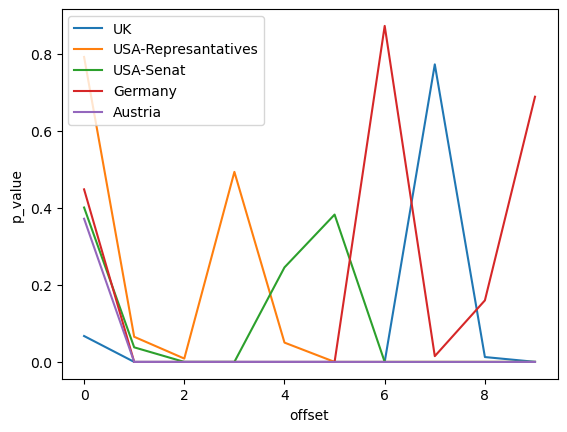

In [7]:
for election in p_values_elections:
    plt.plot(p_values_elections[election],label=election)
plt.xlabel('offset')
plt.ylabel('p_value')
plt.legend()

In [33]:
def group_by_person(election_data,not_election_data)->tuple[pd.Series,pd.Series]:
    # Berechne die Mittelwerte der Änderungen für jede Gruppe
    election_means = election_data.groupby('name')['Changes'].mean()
    not_election_means = not_election_data.groupby('name')['Changes'].mean()

    # Finde die gemeinsamen Namen in beiden DataFrames
    common_names = election_means.index.intersection(not_election_means.index)

    # Filtere die Daten auf die gemeinsamen Namen
    election_means_common = election_means.loc[common_names]
    not_election_means_common = not_election_means.loc[common_names]
    
    return (election_means_common, not_election_means_common)

In [ ]:
## does a wilcoxon test weil abhänige stichproben
for election in datasets:
    print(f'####{election}######')
    election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],3)
    election_data, not_election_data = group_by_person(election_data, not_election_data)
    print(stats.wilcoxon(x=election_data, y=not_election_data))
    

####UK######
WilcoxonResult(statistic=349676.0, pvalue=0.7322716276241241)
####USA-Represantatives######
WilcoxonResult(statistic=121103.0, pvalue=0.49694420610304246)
####USA-Senat######
WilcoxonResult(statistic=4997.0, pvalue=0.3927023714493384)
####Germany######
WilcoxonResult(statistic=151275.0, pvalue=5.295761546194933e-25)
####Austria######
WilcoxonResult(statistic=34181.0, pvalue=5.5400532281260894e-08)


In [44]:
for election in datasets:
    print(f'####{election}######')
    election_data, not_election_data = filter_election_periods(datasets[election],election_times[election],3)
    print(stats.mannwhitneyu(election_data.Changes, not_election_data.Changes, alternative='two-sided'))

####UK######
MannwhitneyuResult(statistic=279030576276.5, pvalue=6.190182418265848e-20)
####USA-Represantatives######
MannwhitneyuResult(statistic=254195309910.0, pvalue=0.4931038856361426)
####USA-Senat######
MannwhitneyuResult(statistic=96857838118.5, pvalue=2.4482690831353547e-06)
####Germany######
MannwhitneyuResult(statistic=7161436566.0, pvalue=4.23310747596975e-32)
####Austria######
MannwhitneyuResult(statistic=404277358.5, pvalue=3.284243037880551e-27)


## testing

In [19]:
stats.ttest_ind(a=election_data.Changes, b=not_election_data.Changes, equal_var=False)

TtestResult(statistic=0.5478099509038079, pvalue=0.583822913722108, df=240429.81976911525)

In [26]:
politician = german[german['Politician']=='Christopher_Gohl']
politician = politician.set_index('Date')

In [46]:
date

Timestamp('2021-04-20 00:00:00')

In [36]:
dates = pd.date_range(start='2010-01-01',end='2024-12-31',unit='s')
df = pd.DataFrame({'date':dates,'Changes':0})
for i,row in df.iterrows():
    date = row.date
    if date in politician.index:
        print(politician[date].Changes)


KeyError: Timestamp('2021-04-20 00:00:00')